In [ ]:
import pyro
import pandas as pd
import numpy as np
import torch
import math
import os
import matplotlib.pyplot as plt
from pyro.infer import SVI, Predictive, TraceEnum_ELBO, config_enumerate
from pyro.optim import ClippedAdam
import pyro.distributions as dist
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import mode
from sklearn.metrics import mean_squared_error
import seaborn as sns

from helper_functions.Clean_data import create_summed_df
from helper_functions.Preprocess_df import standardize_input, standardize_tensor,reverse_standardize_tensor
from helper_functions.utils import split_patient_level

# set random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(0)
torch.set_default_dtype(torch.float64)

save_dir = "outputs/testing_pca_mu_clamp_lower_var_alpha_0.0010_all_data"

In [12]:
saved_model_path=os.path.join(save_dir, "model_params_1000.pt")
saved_loss_path=os.path.join(save_dir,"losses_1000.npy")

## Load data and prepare it

In [13]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")


Loading data file


### Create train and test data split

In [14]:
total_samples=None
(x_emb_train, d_demo_train, v_time_train, c_count_train), (x_emb_test, d_demo_test, v_time_test, c_count_test) = split_patient_level(df, total_samples=total_samples)

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


### Preprocess data
First, we standardize the input $x$ and $d$. Only age and distance is standardized of the $d$ since the other parts are one-hot-encodings. Then a PCA is done one the input $x$ to diminish the dimensions of the bert embeddings of the text, $x$, still covering 95% of the variance. 

In [15]:
x_emb_train_pca, x_emb_test_pca, d_demo_train, d_demo_test = standardize_input(x_emb_train, x_emb_test, d_demo_train, d_demo_test)
print("Standardized x_emb_train shape: ", x_emb_train_pca.shape)
print("Standardized x_emb_test shape: ", x_emb_test_pca.shape)
print("Standardized d_demo_train shape: ", d_demo_train.shape)

Standardized x_emb_train shape:  torch.Size([397607, 151])
Standardized x_emb_test shape:  torch.Size([99591, 151])
Standardized d_demo_train shape:  torch.Size([397607, 8])


The output visitation time, $v$, is log transformed (to allow use of a normal function to estimate) and then standardized. The output visit count is not standardized as it does not make sense for count data. We plot the different versions of $v$.

In [16]:
v_time_train_log = torch.log(v_time_train)
v_time_train_log, v_time_mean, v_time_std = standardize_tensor(v_time_train_log)
v_time_test_log = torch.log(v_time_test)
v_time_test_log, _, _ = standardize_tensor(v_time_test_log, v_time_mean, v_time_std)

## Define model

In [17]:
# Assume data tensors:
# x: [R, D_x] text embeddings
# d: [R, D_d] demographic features
# v: [R] visitation duration, continuous outcome
# c: [R] visitation count, positive integer outcome

torch.set_default_dtype(torch.float64)

# Model definition
@config_enumerate(default="parallel")              # ← enable enumeration
def MixtureModel(x, d, v, c, G=10, device="cpu", batch_size=None):
    x = x.to(dtype=torch.float64, device=device)
    d = d.to(dtype=torch.float64, device=device)
    if v is not None:
        v = v.to(dtype=torch.float64, device=device)
    if c is not None:
        c = c.to(dtype=torch.float64, device=device)

    R, D_x = x.shape
    _, D_d = d.shape

    # Dirichlet prior over cluster proportions
    alpha = torch.ones(G, device=device, dtype=torch.float64)/G
    theta = pyro.sample("theta", dist.Dirichlet(alpha))

    # Group-specific parameters
    with pyro.plate("group", G):
        # Regression weights for visitation duration v
        beta0 = pyro.sample("beta0", dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device)))
        beta_x = pyro.sample("beta_x", dist.Normal(torch.zeros(D_x, device=device), torch.tensor(1e-6, device=device)).to_event(1))
        beta_d = pyro.sample("beta_d", dist.Normal(torch.zeros(D_d, device=device), torch.tensor(1e-6, device=device)).to_event(1))
        sigma = pyro.sample("sigma", dist.HalfCauchy(scale=torch.tensor(5., device=device)))

        # Regression weights for count of c (log-rate)
        prior_mean_count = 1.3  # Adjust this based on your data
        gamma0 = pyro.sample("gamma0", dist.Normal(torch.tensor(math.log(prior_mean_count), device=device), torch.tensor(1., device=device)))
        gamma_x = pyro.sample("gamma_x", dist.Normal(torch.zeros(D_x, device=device), torch.tensor(1e-6, device=device)).to_event(1))
        gamma_d = pyro.sample("gamma_d", dist.Normal(torch.zeros(D_d, device=device), torch.tensor(1e-6, device=device)).to_event(1))

    with pyro.plate("records", R, subsample_size=batch_size) as ind:
        x_b, d_b = x[ind], d[ind]
        
        if v is not None:
            v_b = v[ind]
        else:
            v_b = None

        if c is not None:
            c_b = c[ind]
        else:
            c_b = None

        # Mixture assignment
        g = pyro.sample("g", dist.Categorical(theta), infer={"enumerate":"parallel"})

        # Select parameters for each datum
        bt0 = beta0[g]
        btx = beta_x[g]
        btd = beta_d[g]
        sigma = sigma[g]

        bv0 = gamma0[g]
        bvx = gamma_x[g]
        bvd = gamma_d[g]

        mu_v    = bt0 + (btx * x_b).sum(-1) + (btd * d_b).sum(-1)
        log_lambda = bv0 + (bvx * x_b).sum(-1) + (bvd * d_b).sum(-1)
        log_lambda = torch.clamp(log_lambda, -5.0, 5.4)
        mu_v = torch.clamp(mu_v, -5.0, 5.0)
        
        # Observations
        pyro.sample("obs_logv", dist.Normal(mu_v, sigma), obs=v_b)
        pyro.sample("obs_c", dist.Poisson(log_lambda.exp()), obs=c_b)
        

# Guide (Mean-field VI)
def MixtureModelGuide(x,d, v=None, c=None, G=10, device="cpu", batch_size=None):
    x = x.to(device=device, dtype=torch.float64)
    d = d.to(device=device, dtype=torch.float64)

    N, D_x = x.shape
    _, D_d = d.shape
    
    # Learnable Dirichlet concentration
    q_alpha = pyro.param("q_alpha", torch.ones(G, dtype=torch.float64, device=device), constraint=dist.constraints.positive)
    theta = pyro.sample("theta", dist.Dirichlet(q_alpha))

    # Group params
    with pyro.plate("group", G):
        for name, shape, constraint in [
            ("beta0", [G], None),
            ("gamma0", [G], None)
        ]:
            pyro.param(f"loc_{name}", torch.zeros(*shape, device=device , dtype=torch.float64))
            pyro.param(f"scale_{name}", torch.ones(*shape, device=device, dtype=torch.float64), constraint=dist.constraints.positive)
            pyro.sample(name, dist.Normal(pyro.param(f"loc_{name}"), pyro.param(f"scale_{name}")))

        #pyro.param("loc_sigma", torch.zeros(G))
        pyro.param("scale_sigma", torch.ones(G, device=device, dtype=torch.float64), constraint=dist.constraints.positive)
        pyro.sample("sigma", dist.HalfCauchy(pyro.param("scale_sigma")))

        pyro.param("loc_beta_x", torch.zeros(G, D_x, dtype=torch.float64, device=device))
        pyro.param("scale_beta_x", torch.ones(G, D_x, dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("beta_x", dist.Normal(pyro.param("loc_beta_x"), pyro.param("scale_beta_x")).to_event(1))

        pyro.param("loc_beta_d", torch.zeros(G, D_d, dtype=torch.float64, device=device))
        pyro.param("scale_beta_d", torch.ones(G, D_d, dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("beta_d", dist.Normal(pyro.param("loc_beta_d"), pyro.param("scale_beta_d")).to_event(1))

        pyro.param("loc_gamma_x", torch.zeros(G, D_x,dtype=torch.float64, device=device))
        pyro.param("scale_gamma_x", torch.ones(G, D_x,dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("gamma_x", dist.Normal(pyro.param("loc_gamma_x"), pyro.param("scale_gamma_x")).to_event(1))

        pyro.param("loc_gamma_d", torch.zeros(G, D_d,dtype=torch.float64, device=device))
        pyro.param("scale_gamma_d", torch.ones(G, D_d,dtype=torch.float64, device=device), constraint=dist.constraints.positive)
        pyro.sample("gamma_d", dist.Normal(pyro.param("loc_gamma_d"), pyro.param("scale_gamma_d")).to_event(1))

The model is now trained using Stochastical Variational Inference (SVI). 

In [18]:
#Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)
cuda_gen = torch.Generator(device=device).manual_seed(42)
x_emb_train, x_emb_train_pca, d_demo_train, v_time_train, c_count_train, v_time_train_log = [
    tensor.to(device) for tensor in [x_emb_train, x_emb_train_pca, d_demo_train, v_time_train, c_count_train, v_time_train_log]
]

Using device: cuda


In [19]:

def load_model_and_losses(model_path="model_params.pt", losses_path="losses.npy", device="cpu"):
    """
    Load the model parameters and losses from files, and move them to the specified device.

    Args:
        model_path (str): Path to the saved model parameters.
        losses_path (str): Path to the saved losses.
        device (str or torch.device): Device to move the parameters to (e.g., "cpu" or "cuda:0").

    Returns:
        list: Loaded losses.
    """
    # Load model parameters
    loaded_params = torch.load(model_path, map_location=torch.device(device))
    for name, param in loaded_params.items():
        pyro.param(name, param.to(device))
    print(f"Model parameters loaded from {model_path} and moved to {device}")

    # Load losses
    losses = np.load(losses_path).tolist()
    print(f"Losses loaded from {losses_path}")

    return losses

In [20]:
# Example usage:
losses = load_model_and_losses(
    model_path=saved_model_path,
    losses_path=saved_loss_path,
    device=device)
G=10
num_steps=1000

Model parameters loaded from outputs/testing_pca_mu_clamp_lower_var_alpha_0.0010_all_data\model_params_1000.pt and moved to cuda
Losses loaded from outputs/testing_pca_mu_clamp_lower_var_alpha_0.0010_all_data\losses_1000.npy


In [21]:
# Setup DataLoader
batch_size = 2**11 #max is 2**17
dataset = TensorDataset(x_emb_train_pca, d_demo_train, v_time_train_log, c_count_train)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        generator=cuda_gen, 
                        num_workers=4,
                        persistent_workers=True
                    )

G=10
R = len(x_emb_train)

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})
svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

In [22]:
num_steps = len(losses)

### Plot of loss curves
We plot the loss curve for the training to see if convergence is achieved.

## Predictions
The predictions are computed by sampling 200 samples from the trained model with the input from the test data. The mean is then taken of the 200 samples which we use as the prediction.

In [23]:
# investigate v_time_test
print("v_time_test shape: ", v_time_test.shape)
print("v_time_test mean: ", v_time_test.mean().item())
print("v_time_test std: ", v_time_test.std().item())
print("v_time_test min: ", v_time_test.min().item())
print("v_time_test max: ", v_time_test.max().item())

v_time_test shape:  torch.Size([99591])
v_time_test mean:  4.133657932281494
v_time_test std:  8.70018196105957
v_time_test min:  0.019999999552965164
v_time_test max:  590.1199951171875


In [41]:
#baseline rmse
baseline_rmse_v = np.sqrt( mean_squared_error(
    v_time_test.cpu().numpy(), 
    np.full(v_time_test.shape, v_time_train.cpu().numpy().mean()).reshape(-1)
))

baseline_rmse_c = np.sqrt(mean_squared_error(
    c_count_test.cpu().numpy(), 
    np.full(c_count_test.shape, c_count_train.cpu().numpy().mean()).reshape(-1)
))
print(f"Baseline v: {v_time_train.cpu().numpy().mean():.4f}")
print(f"Baseline c: {c_count_train.cpu().numpy().mean():.4f}")
print(f"Baseline RMSE v: {baseline_rmse_v:.4f}")
print(f"Baseline RMSE c: {baseline_rmse_c:.4f}")

Baseline v: 4.0947
Baseline c: 3.6566
Baseline RMSE v: 8.7002
Baseline RMSE c: 5.4262


In [25]:
predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      
    return_sites=["obs_logv", "obs_c"]
)

rmse_v_all = []
rmse_c_all = []
for i in range(50):

    samples = predictive(x_emb_test_pca, d_demo_test, None, None, G, device)
    # Compute mean of predictions and reverse standardization and reverse log transformation
    pred_v_log = samples["obs_logv"].mean(0)
    pred_v_log = reverse_standardize_tensor(pred_v_log, v_time_mean, v_time_std)
    pred_v = torch.exp(pred_v_log)
    pred_v = pred_v.cpu().numpy()

    # Get the “true” values by reversing the standardization and log transformation
    v_time_test_log_reversed = reverse_standardize_tensor(v_time_test_log, v_time_mean, v_time_std)
    true_v = torch.exp(v_time_test_log_reversed)
    true_v   = true_v.cpu().numpy()

    # Get predicted counts
    pred_c = samples["obs_c"].mean(dim=0).cpu().numpy()
    # Get true counts
    true_c = c_count_test.cpu().numpy()

    rmse_v = np.sqrt(mean_squared_error(true_v, pred_v))
    rmse_c = np.sqrt(mean_squared_error(true_c, pred_c))
    rmse_v_all.append(rmse_v)
    rmse_c_all.append(rmse_c)


RMSE for visitation duration (v): 8.9667
RMSE for visitation count (c): 7.1192


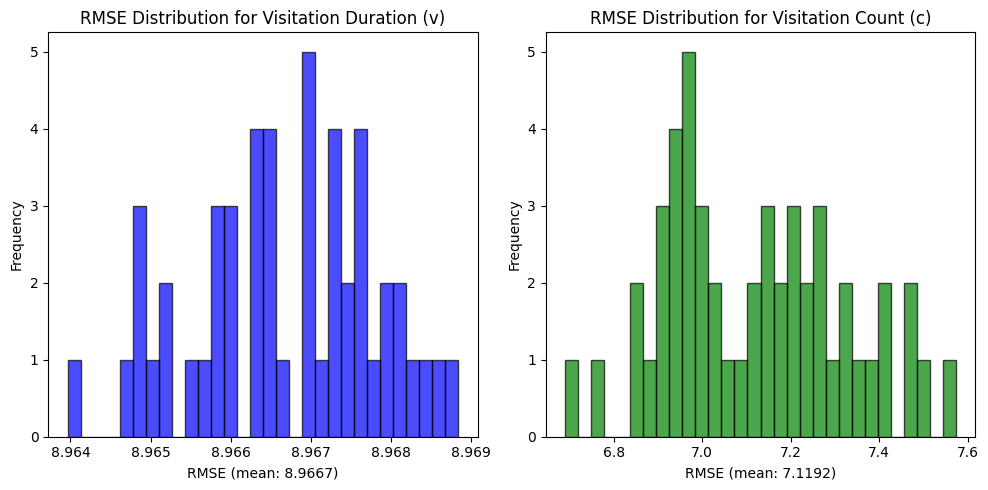

In [31]:
# filter out values that are above 1e5

rmse_v_all_filtered = [x for x in rmse_v_all if x < 1e3]
rmse_v_mean = np.mean(rmse_v_all_filtered)
rmse_c_mean = np.mean(rmse_c_all)
print(f"RMSE for visitation duration (v): {rmse_v_mean:.4f}")
print(f"RMSE for visitation count (c): {rmse_c_mean:.4f}")
# Plotting the RMSE results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(rmse_v_all_filtered, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('RMSE Distribution for Visitation Duration (v)')
plt.xlabel(f'RMSE (mean: {rmse_v_mean:.4f})')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(rmse_c_all, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('RMSE Distribution for Visitation Count (c)')
plt.xlabel(f'RMSE (mean: {rmse_c_mean:.4f})')
plt.ylabel('Frequency')
plt.tight_layout() 
plt.savefig(os.path.join(save_dir,"rmse_histograms.png"))
plt.show()

## Explore learned parameters

Group counts: [    0     0     0     0 99591     0     0     0     0     0]
Group counts: [ 1061509   742763   686346  1622839 11698666   529702   752394   777019
   741259  1305703]
Theta (group proportions): [[0.05324628 0.0373019  0.03448931 0.08139113 0.5874301  0.02663477
  0.03773165 0.03905885 0.03720846 0.06550755]]


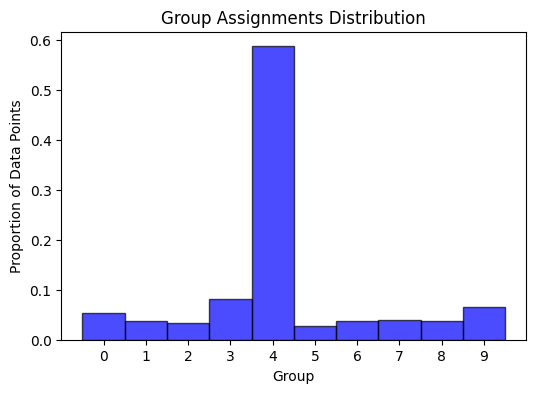

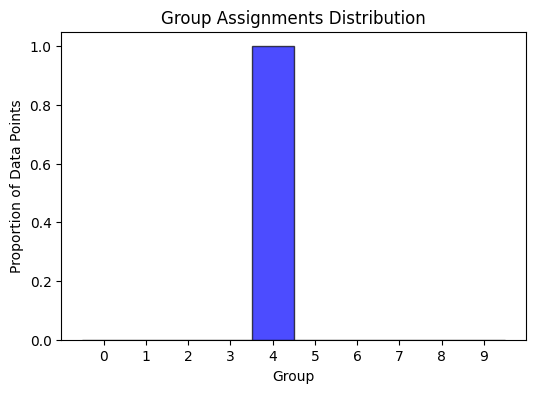

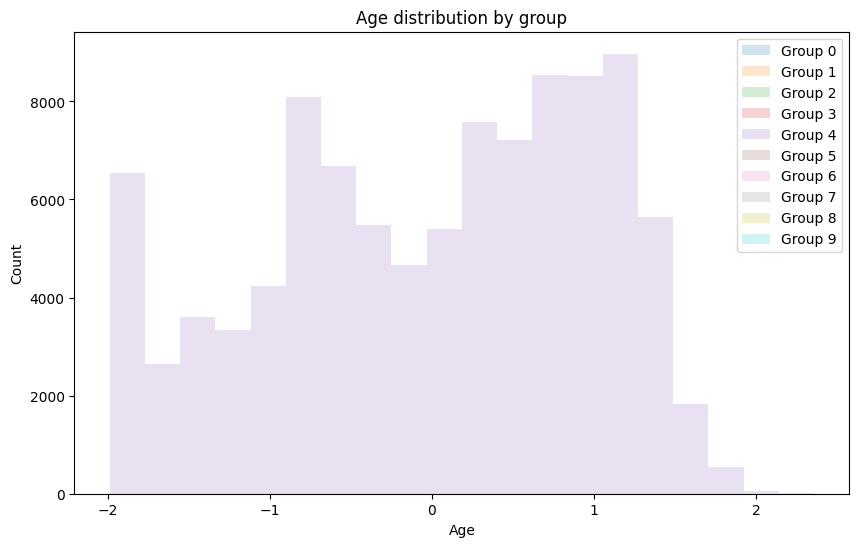

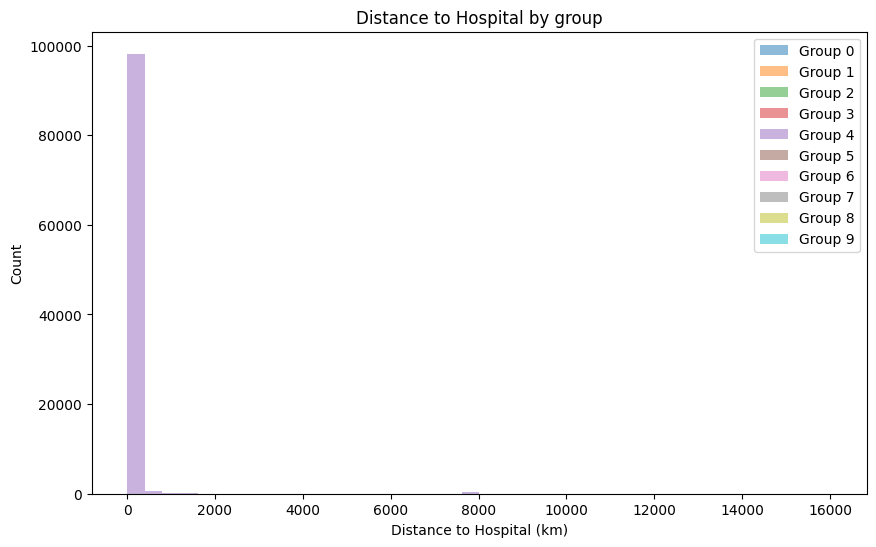

In [35]:
predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,
    return_sites=["g", "theta"]
)
samples = predictive(x_emb_test_pca, d_demo_test, None, None, G, device)
# Shape: (num_samples, num_data_points)
group_assignments = samples["g"].cpu().numpy()
majority_group = mode(group_assignments, axis=0).mode.squeeze()

# Print number in each group
group_counts = np.bincount(majority_group, minlength=G)
print("Group counts:", group_counts)

group_counts = np.bincount(group_assignments.flatten(), minlength=G)
print("Group counts:", group_counts)

print("Theta (group proportions):", samples["theta"].mean(0).cpu().numpy())

# Plot all group assignments
plt.figure(figsize=(6, 4))
plt.hist(group_assignments.flatten(), bins=np.arange(G + 1) - 0.5, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xticks(np.arange(G))
plt.xlabel("Group")
plt.ylabel("Proportion of Data Points")
plt.title("Group Assignments Distribution")
plt.show()

# Plotting the group assignments
plt.figure(figsize=(6, 4))
plt.hist(majority_group, bins=np.arange(G + 1) - 0.5, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.xticks(np.arange(G))
plt.xlabel("Group")
plt.ylabel("Proportion of Data Points")
plt.title("Group Assignments Distribution")
plt.show()
# Convert demographic data tensor to numpy
d_demo_test_np = d_demo_test.cpu().numpy()

# Index for "age" in your demographic data
age_idx = 0

# Plot histograms of age for each group
plt.figure(figsize=(10, 6))
for g in range(G):
    # Select indices for this group
    group_mask = (majority_group == g)
    age_data = d_demo_test_np[group_mask, age_idx]
    
    # Plot histogram
    plt.hist(age_data, bins=20, alpha=0.2, label=f"Group {g}")

plt.legend()
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution by group")
plt.show()

# Index for "distance to hospital" in your demographic data
distance_idx = 1

plt.figure(figsize=(10, 6))
for g in range(G):
    group_mask = (majority_group == g)
    distance_data = d_demo_test_np[group_mask, distance_idx]
    
    plt.hist(distance_data, bins=40, alpha=0.5, label=f"Group {g}")

plt.legend()
plt.xlabel("Distance to Hospital (km)")
plt.ylabel("Count")
plt.title("Distance to Hospital by group")
plt.show()


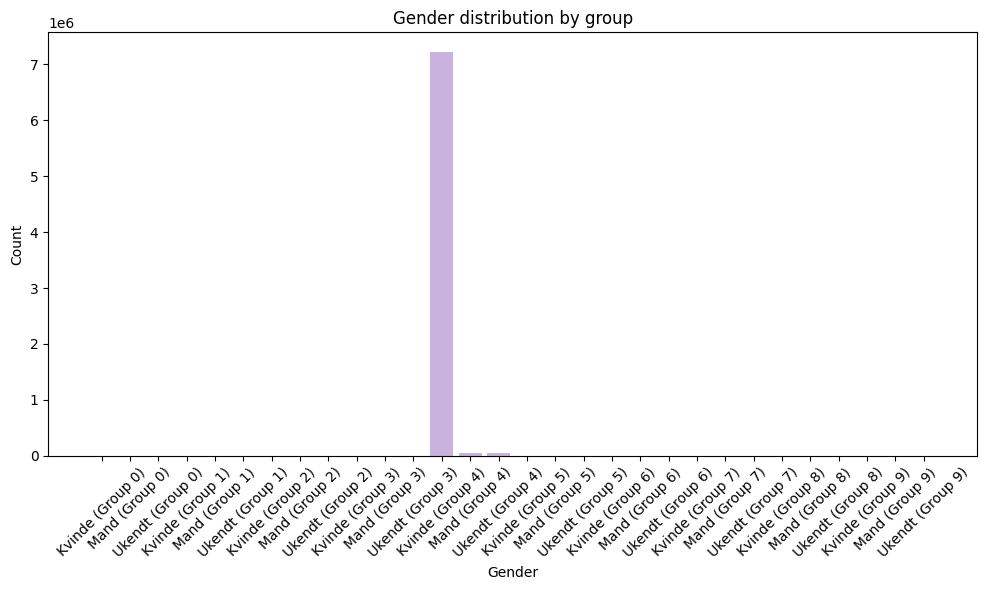

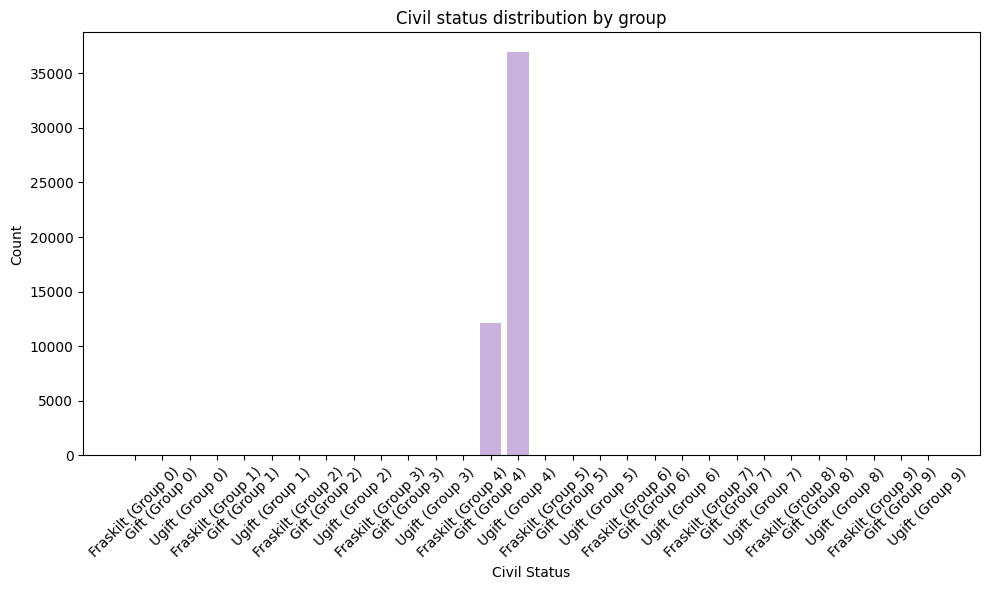

In [28]:
# Gender columns: 2, 3, 4
gender_cols = [1, 2, 3]

# Civil status columns: 5, 6, 7
civil_cols = [4, 5, 6]

# Gender mapping
gender_labels = ["Kvinde", "Mand", "Ukendt"]
civil_labels = ["Fraskilt", "Gift", "Ugift"]

# Plot gender distribution by group
plt.figure(figsize=(10, 6))
for g in range(G):
    group_mask = (majority_group == g)
    gender_data = d_demo_test_np[group_mask][:, gender_cols]
    
    # Sum across data points to get counts
    gender_counts = gender_data.sum(axis=0)
    
    plt.bar(
        [f"{label} (Group {g})" for label in gender_labels],
        gender_counts,
        alpha=0.5
    )

plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender distribution by group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot civil status distribution by group
plt.figure(figsize=(10, 6))
for g in range(G):
    group_mask = (majority_group == g)
    civil_data = d_demo_test_np[group_mask][:, civil_cols]
    civil_counts = civil_data.sum(axis=0)
    
    plt.bar(
        [f"{label} (Group {g})" for label in civil_labels],
        civil_counts,
        alpha=0.5
    )

plt.xlabel("Civil Status")
plt.ylabel("Count")
plt.title("Civil status distribution by group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


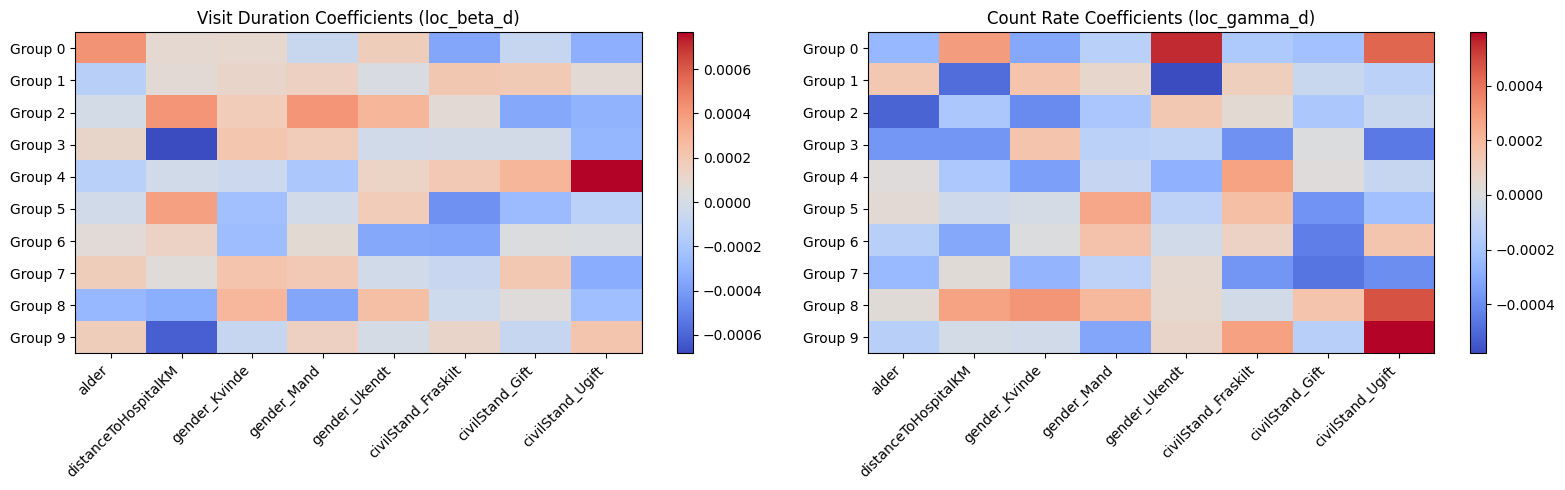

In [ ]:
param_store = pyro.get_param_store()
heatmap_path=os.path.join(save_dir, "params_heatmap_demographic.pdf")

# Demographic coefficient means
loc_beta_d = param_store["loc_beta_d"].detach().cpu().numpy()   # shape: (G, D_d)
loc_gamma_d = param_store["loc_gamma_d"].detach().cpu().numpy() # shape: (G, D_d)

# Visualize as heatmaps
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
demo_cols = ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt',
              'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']

im1 = axs[0].imshow(loc_beta_d, cmap="coolwarm", aspect="auto")
axs[0].set_title("Visit Duration Coefficients (loc_beta_d)")
axs[0].set_xticks(range(len(demo_cols)))
axs[0].set_xticklabels(demo_cols, rotation=45, ha="right")
axs[0].set_yticks(range(loc_beta_d.shape[0]))
axs[0].set_yticklabels([f"Group {g}" for g in range(loc_beta_d.shape[0])])
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(loc_gamma_d, cmap="coolwarm", aspect="auto")
axs[1].set_title("Count Rate Coefficients (loc_gamma_d)")
axs[1].set_xticks(range(len(demo_cols)))
axs[1].set_xticklabels(demo_cols, rotation=45, ha="right")
axs[1].set_yticks(range(loc_gamma_d.shape[0]))
axs[1].set_yticklabels([f"Group {g}" for g in range(loc_gamma_d.shape[0])])
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.savefig(heatmap_path)
plt.show()